### Hyper-parameter Tunning with Genetic Algorithm
#### Created: Dec. 29 2018

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
import sys
sys.path.append("../")
# If this notebook file is not placed under in /notebook/ directory,
# adding directory "../" might not correly add the project directory.
# If adding "../" does not solve the importing problem, we need to setup 
# the directory mannually.
try:
    import constants
except ModuleNotFoundError:
    core_dir = input("Directory of core files >>> ")
    if not core_dir.endswith("/"):
        core_dir += "/"
    sys.path.append(core_dir)
    import constants

In [3]:
import core.genetic.control as control
import core.genetic.tuner as tuner
import core.models.stacked_lstm as stacked_lstm

In [4]:
# Load dataset.
print("Dataset paths saved:")
pprint(constants.DATA_DIR)
choice = None
while choice is None or choice not in constants.DATA_DIR.keys():
    if choice is not None:
        print("Invalid data location received, try again...")
    choice = input("Select Dataset >>> ")
FILE_DIR = constants.DATA_DIR[choice]
print(f"Dataset chosen: {FILE_DIR}")

Dataset paths saved:
{'a': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv',
 'b': '/home/ec2-user/AnnEconForecast/data/UNRATE.csv',
 'c': '/home/ec2-user/AnnEconForecast/data/DEXCAUS.csv'}
Select Dataset >>> b
Dataset chosen: /home/ec2-user/AnnEconForecast/data/UNRATE.csv


In [5]:
# Load configuration.
print("Avaiable configuration files found: ")
for cf in os.listdir("../hps_configs"):
    print("\t" + cf)

config_name = input("Select config file >>> ")
if config_name.endswith(".py"):
    config_name = config_name[:-3]
# config_name = "mac_config"

exec(f"import hps_configs.{config_name} as config")

Avaiable configuration files found: 
	__pycache__
	ec2_config.py
	mac_config.py
	.ipynb_checkpoints
	ec2_lite_config.py
	template.py
Select config file >>> ec2_lite_config


In [6]:
# Training Spec.
GENE_POOL = config.main
TOTAL_GEN = 5
POP_SIZE = 10
IGNORE_SET = (
    "PERIODS", "ORDER", "TRAIN_RATIO", "VAL_RATIO", "num_outputs", "num_inputs", "report_periods",
    "tensorboard_path", "model_path", "fig_path"
)

In [7]:
def eval_net_wrapper(param):
    return control.eval_net(
        model=stacked_lstm.StackedLSTM,
        param=param,
        file_dir=FILE_DIR,
        metric="mse_val",
        smooth_metric=0.05
    )

In [8]:
# Create the Optimizer.
optimizer = tuner.GeneticTuner(
    gene_pool=config.main,
    pop_size=POP_SIZE,
    eval_func=eval_net_wrapper,
    mode="min",
    retain=0.5,
    shot_prob=0.05,
    mutate_prob=0.05,
    verbose=False,
    ignore=IGNORE_SET
)

In [9]:
start_time = datetime.datetime.now()

In [10]:
elite = control.train_op(
    optimizer=optimizer,
    total_gen=TOTAL_GEN,
    elite=0.5
)

Generation: [0/5]
Evaluating the initial population.
 #--------- Evaluating... [1/10,  10.00%]
 ##-------- Evaluating... [2/10,  20.00%]lr= 0.0300
 ###------- Evaluating... [3/10,  30.00%], lr= 0.0100
 ####------ Evaluating... [4/10,  40.00%] 0.0100
 #####----- Evaluating... [5/10,  50.00%] lr= 0.0100
 ######---- Evaluating... [6/10,  60.00%] 0.0100
 #######--- Evaluating... [7/10,  70.00%]r= 0.0100
 ########-- Evaluating... [8/10,  80.00%] lr= 0.0030
 #########- Evaluating... [9/10,  90.00%] lr= 0.0030
 ########## Evaluating... [10/10, 100.00%] 0.0030
Current Net: size=(128, 256), ep=500, lr= 0.0030
Best fitted entity validatiton MSE:  0.0237705        
Worst fitted entity validation MSE:  0.0371916
Generation: [1/5]
 #---------- Evaluating... [1/11,   9.09%]
 ##--------- Evaluating... [2/11,  18.18%]= 0.0100
 ###-------- Evaluating... [3/11,  27.27%]0.0030
 ####------- Evaluating... [4/11,  36.36%]lr= 1.0058
 #####------ Evaluating... [5/11,  45.45%] 0.0030
 ######----- Evaluating...

In [11]:
end_time = datetime.datetime.now()
print(f"Time taken: {end_time - start_time}")

Time taken: 0:06:04.017001


In [12]:
list(elite.values())[-1][0]

({'PERIODS': 1,
  'ORDER': 1,
  'LAGS': 5,
  'TRAIN_RATIO': 0.8,
  'VAL_RATIO': 0.1,
  'epochs': 500,
  'num_inputs': 1,
  'num_outputs': 1,
  'num_time_steps': 5,
  'num_neurons': [66, 330],
  'learning_rate': 0.004223078586367626,
  'clip_grad': None,
  'report_periods': 10,
  'tensorboard_path': '/home/ec2-user/ec2_hps/2018DEC21_01/tensorboard/',
  'model_path': '/home/ec2-user/ec2_hps/2018DEC21_01/saved_models/',
  'fig_path': '/home/ec2-user/ec2_hps/2018DEC21_01/model_figs/'},
 0.022768879309296608)

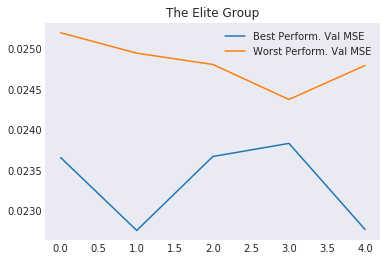

In [15]:
plt.close()
plt.style.use('seaborn-dark')
plt.title("The Elite Group")
plt.plot([
    elite_gp[0][1] 
    for elite_gp in list(elite.values())])
plt.plot([
    elite_gp[-1][1] 
    for elite_gp in list(elite.values())])
plt.legend(
    ["Best Perform. Val MSE", "Worst Perform. Val MSE"],
    loc="best"
)
plt.show()